# Random Forest Rangers - Predicting Car Sales Prices
## Training the models

### Prerequisites

In [34]:
# Install dependencies
!pip install -q -r requirements.txt

# On MacOS you need the following command
# brew install libomp

In [35]:
# Import neccessary modules
import pandas as pd
import numpy as np

In [36]:
dataset = pd.read_csv('./data/used_car_prices_preprocessed.csv')
print(dataset.dtypes)

print(dataset.head(10))

model_year         int64
milage           float64
accident           int64
clean_title        int64
price            float64
turbo              int64
brand_encoded      int64
engine_score     float64
dtype: object
   model_year    milage  accident  clean_title    price  turbo  brand_encoded  \
0        2013   51000.0         1            1  10300.0      0              4   
1        2021   34742.0         1            1  38005.0      0              2   
2        2022   22372.0         0            0  54598.0      0              4   
3        2015   88900.0         0            1  15500.0      0              2   
4        2021    9835.0         0            0  34999.0      1              4   
5        2016  136397.0         0            0  14798.0      0              3   
6        2017   84000.0         0            1  31000.0      0              4   
7        2001  242000.0         0            1   7300.0      0              4   
8        2021   23436.0         0            1  41927.0  

### Remove target variable

In [ ]:
# Define the features and target variable
X = dataset.drop(columns=['price'])
y = dataset['price']

### Model Training

#### Linear Regression

Testing hyperparameters: {'fit_intercept': True}
Mean R² for {'fit_intercept': True}: 0.3057
Testing hyperparameters: {'fit_intercept': False}
Mean R² for {'fit_intercept': False}: -0.0841
Best hyperparameters: {'fit_intercept': True} with Mean R²: 0.3057


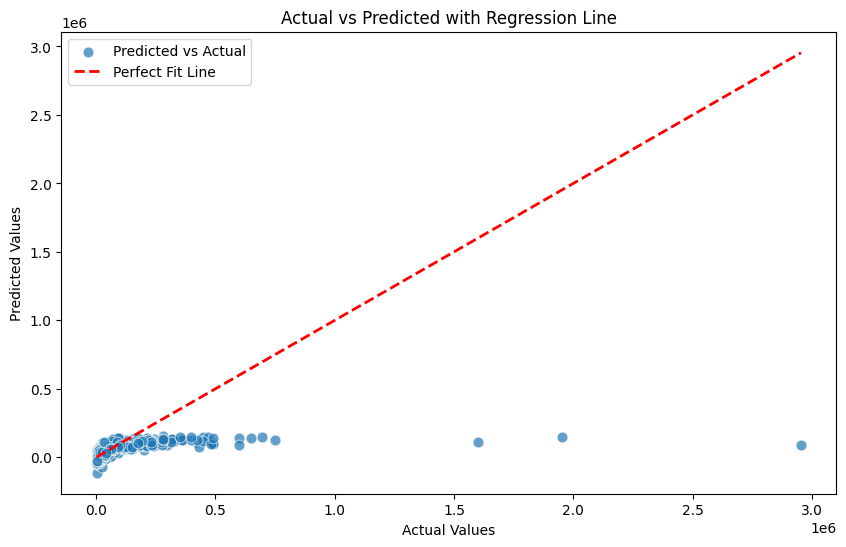

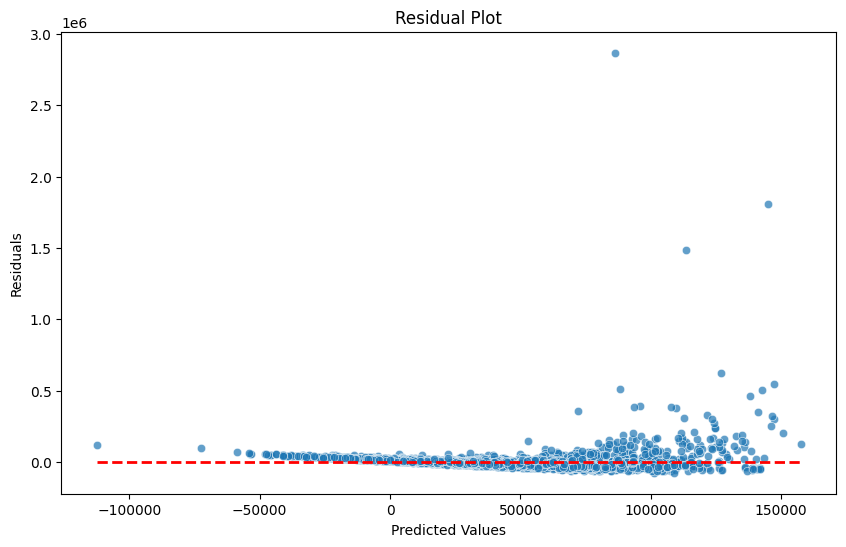

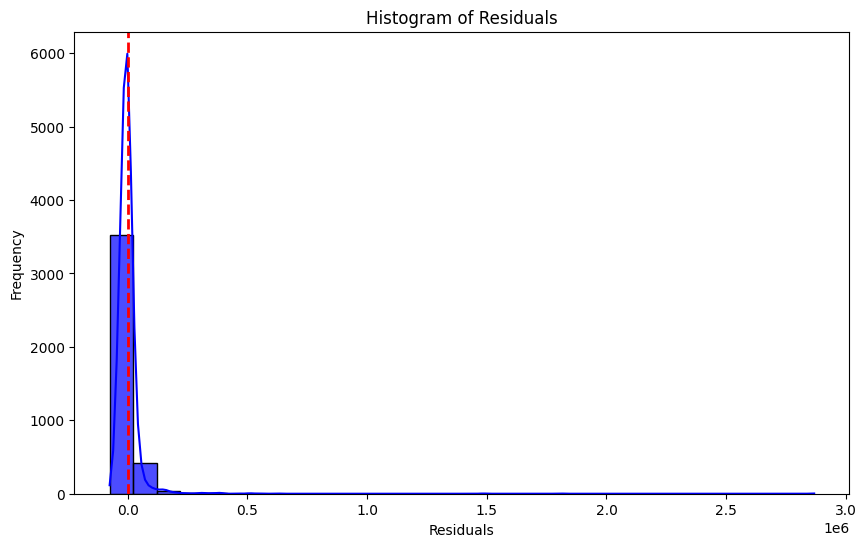

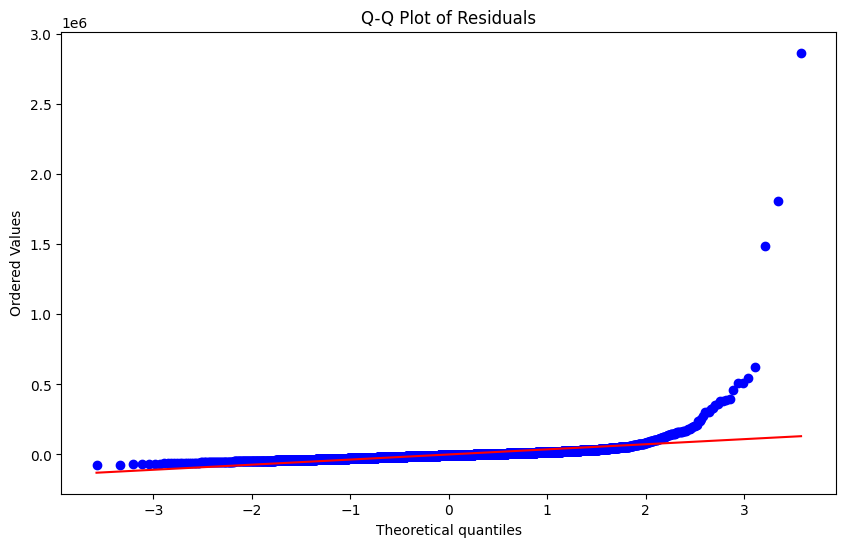

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, KFold
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Define hyperparameter grid
param_grid = [{'fit_intercept': True}, {'fit_intercept': False}]

# Initialize variables to store results
results = []

# RobustScaler for consistent scaling
scaler = RobustScaler()

# Iterate over all hyperparameter combinations
for params in param_grid:
    print(f"Testing hyperparameters: {params}")
    mse_scores = []  # Store MSE for each fold
    r2_scores = []   # Store R² for each fold

    # Perform K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X, y):
        # Split the data
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Scale the data
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_test_fold = scaler.transform(X_test_fold)

        # Create a new model for this fold with the current hyperparameters
        model = LinearRegression(**params)

        # Fit the model
        model.fit(X_train_fold, y_train_fold)

        # Predict on the test fold
        y_pred = model.predict(X_test_fold)

        # Calculate metrics
        mse = mean_squared_error(y_test_fold, y_pred)
        r2 = r2_score(y_test_fold, y_pred)

        # Store results for this fold
        mse_scores.append(mse)
        r2_scores.append(r2)

    # Calculate mean R² and store results
    mean_r2 = np.mean(r2_scores)
    results.append({'params': params, 'mean_r2': mean_r2})
    print(f"Mean R² for {params}: {mean_r2:.4f}")

# Train the final model with the best hyperparameters on the full dataset
X_copy = X.copy()
y_copy = y.copy()

# Select the best hyperparameters
best_result = max(results, key=lambda x: x['mean_r2'])
best_params = best_result['params']
print(f"Best hyperparameters: {best_params} with Mean R²: {best_result['mean_r2']:.4f}")

# Train final model on the full dataset with the best hyperparameters
final_model = LinearRegression(**best_params)
X_scaled = scaler.fit_transform(X_copy)
final_model.fit(X_scaled, y_copy)

# Predict on the full dataset
y_pred_full = final_model.predict(X_scaled)

# --- Visualization ---
# 1. Plot: Actual vs Predicted with the Regression Line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_copy, y=y_pred_full, label="Predicted vs Actual", alpha=0.7, s=60)
plt.plot([min(y_copy), max(y_copy)], [min(y_copy), max(y_copy)], 'r--', label='Perfect Fit Line', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted with Regression Line')
plt.legend()
plt.show()

# 2. Residual Plot
residuals = y - y_pred_full
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_full, y=residuals, alpha=0.7)
plt.hlines(y=0, xmin=min(y_pred_full), xmax=max(y_pred_full), colors='red', linestyles='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue', bins=30, alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# 4. Q-Q Plot
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plots


#### Random Forest Regression

In [49]:
from sklearn.ensemble import RandomForestRegressor
from itertools import product

# Define hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Generate all combinations of hyperparameters
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf']
))

param_array = [
    {
        'n_estimators': combo[0],
        'max_depth': combo[1],
        'min_samples_split': combo[2],
        'min_samples_leaf': combo[3]
    } for combo in param_combinations
]

print(param_array)

# Initialize variables to store results
results = []

# RobustScaler for consistent scaling
scaler = RobustScaler()
index = 1
length = len(param_array)

# Iterate over all hyperparameter combinations
for params in param_array:
    mse_scores = []  # Store MSE for each fold
    r2_scores = []   # Store R² for each fold

    # Perform K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X, y):
        # Split the data
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Scale the data
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_test_fold = scaler.transform(X_test_fold)

        # Create a new model for this fold with the current hyperparameters
        model = RandomForestRegressor(**params)

        # Fit the model
        model.fit(X_train_fold, y_train_fold)

        # Predict on the test fold
        y_pred = model.predict(X_test_fold)

        # Calculate metrics
        mse = mean_squared_error(y_test_fold, y_pred)
        r2 = r2_score(y_test_fold, y_pred)

        # Store results for this fold
        mse_scores.append(mse)
        r2_scores.append(r2)

    # Calculate mean R² and store results
    mean_r2 = np.mean(r2_scores)
    results.append({'params': params, 'mean_r2': mean_r2})
    if index % 100 == 0:
        print(f"Run {index} of {len}")
    index = index + 1

# Train the final model with the best hyperparameters on the full dataset
X_copy = X.copy()
y_copy = y.copy()

# Select the best hyperparameters
best_result = max(results, key=lambda x: x['mean_r2'])
best_params = best_result['params']
print(f"Best hyperparameters: {best_params} with Mean R²: {best_result['mean_r2']:.4f}")

# Train final model on the full dataset with the best hyperparameters
final_model = RandomForestRegressor(**best_params)
X_scaled = scaler.fit_transform(X_copy)
final_model.fit(X_scaled, y_copy)

# Predict on the full dataset
y_pred_full = final_model.predict(X_scaled)


[{'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}, {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2}, {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 4}, {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1}, {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2}, {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 4}, {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1}, {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 2}, {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 4}, {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}, {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2}, {'n_estimators': 10, 'max_depth'

#### XGBoost

In [26]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost regressor
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Cross-validation loop
mse_scores = []          # Store MSE for each fold
r2_scores = []           # Store R² for each fold
adjusted_r2_scores = []  # Store Adjusted R² for each fold

n = len(dataset)  # Total number of samples
p = X.shape[1]    # Number of predictors
i = 1

x_copy = X.copy()
y_copy = y.copy()

for train_index, test_index in kf.split(X):
    # Split the data
    X_train_fold, X_test_fold = x_copy.iloc[train_index], x_copy.iloc[test_index]
    y_train_fold, y_test_fold = y_copy.iloc[train_index], y_copy.iloc[test_index]

    # Train the model
    model.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    y_pred = model.predict(X_test_fold)

    # Calculate MSE
    mse = mean_squared_error(y_test_fold, y_pred)
    mse_scores.append(mse)

    # Calculate R²
    r2 = r2_score(y_test_fold, y_pred)
    r2_scores.append(r2)

    # Calculate Adjusted R²
    n_fold = len(y_test_fold)  # Number of samples in this fold
    adjusted_r2 = 1 - ((1 - r2) * (n_fold - 1)) / (n_fold - p - 1)
    adjusted_r2_scores.append(adjusted_r2)

    print(f"Run {i}:\nMSE: {mse}\nRMSE: {np.sqrt(mse)}\nR2: {r2}\nAdjusted R2: {adjusted_r2}\n")
    i = i + 1

# Average metrics across folds
avg_mse = sum(mse_scores) / len(mse_scores)
avg_r2 = sum(r2_scores) / len(r2_scores)
avg_adjusted_r2 = sum(adjusted_r2_scores) / len(adjusted_r2_scores)

print(f"Average MSE: {avg_mse:.2f}")
print(f"Average R²: {avg_r2:.2f}")
print(f"Average Adjusted R²: {avg_adjusted_r2:.2f}")


Run 1:
MSE: 16839261939.352365
RMSE: 129766.18180154783
R2: 0.17614406386072512
Adjusted R2: 0.16888085031793554

Run 2:
MSE: 1328310954.1040113
RMSE: 36446.00052274613
R2: 0.5631424572909156
Adjusted R2: 0.5592910683753444

Run 3:
MSE: 37611272031.830284
RMSE: 193936.2576514002
R2: -16.710491056944214
Adjusted R2: -16.86662888742105

Run 4:
MSE: 1181310078.978533
RMSE: 34370.19172158533
R2: 0.6248431049986214
Adjusted R2: 0.6215356764532691

Run 5:
MSE: 599176123.4474512
RMSE: 24478.07434108025
R2: 0.723074107522736
Adjusted R2: 0.7206296166685862

Average MSE: 11511866225.54
Average R²: -2.92
Average Adjusted R²: -2.96
